# 2D interpolation of ABC satellite data
In this notebook, we look at a more practical example to generate gridded predictions of the sea-ice freeboard from satellite data using ``GPSat``. For the satellite data, we use a sample of the Sentinel 3A and 3B data as well as CryoSat-2 data (referred to as A, B and C respectively).

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data
from GPSat.config_dataclasses import DataConfig, ModelConfig, PredictionLocsConfig, ExpertLocsConfig
from GPSat.postprocessing import glue_local_predictions_2d


could not import global_land_mask, won't reduce grid points to just those over ocean


2023-08-04 04:36:41.650432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 04:36:42.212118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


We read in the raw ABC satellite data saved in this repo for demo purposes. We combine the data sources into a single dataframe.

In [2]:
# read in all the *_RAW.csv files in data/example
# - get files to read
raw_files = [get_data_path("example", i)
             for i in os.listdir(get_data_path("example")) if re.search("_RAW\.csv$", i)]

# read in, add source col
tmp = []
for file in raw_files:
    source = re.sub("_RAW\.csv$", "", os.path.basename(file))
    sat_data = pd.read_csv(file)
    sat_data['source'] = source
    tmp.append(sat_data)
df = pd.concat(tmp)

df.head()

,lon,lat,datetime,z,source
0,59.944790,82.061122,2020-03-01 13:48:50.295540,0.0599,C
1,59.939555,82.063771,2020-03-01 13:48:50.354648,0.0139,C
2,59.934316,82.066419,2020-03-01 13:48:50.413756,0.1648,C
3,59.929074,82.069068,2020-03-01 13:48:50.472864,0.1516,C
4,59.923829,82.071716,2020-03-01 13:48:50.531972,0.1222,C


Here, the variable ``z`` signifies the freeboard measurement that we wish to interpolate. For convenience, we will convert the ``lon``, ``lat`` variables into ``x``, ``y`` EASE(2) grid coordinates and the ``datetime`` column to ``t`` UTC days. 

In [3]:
# convert lon, lat, datetime to x, y, t - to be used as the coordinate space
# - x,y are in meters, t in days
df['x'], df['y'] = WGS84toEASE2_New(lon=df['lon'], lat=df['lat'], lat_0=90, lon_0=0)
df['t'] = df['datetime'].values.astype("datetime64[D]").astype(float)

df.head()

,lon,lat,datetime,z,source,x,y,t
0,59.944790,82.061122,2020-03-01 13:48:50.295540,0.0599,C,766835.526399,-443718.474582,18322.0
1,59.939555,82.063771,2020-03-01 13:48:50.354648,0.0139,C,766539.591915,-443640.730012,18322.0
2,59.934316,82.066419,2020-03-01 13:48:50.413756,0.1648,C,766243.660921,-443562.985865,18322.0
3,59.929074,82.069068,2020-03-01 13:48:50.472864,0.1516,C,765947.724567,-443485.235174,18322.0
4,59.923829,82.071716,2020-03-01 13:48:50.531972,0.1222,C,765651.791742,-443407.484810,18322.0


We bin the raw data to a 50km grid to reduce the total data size.

In [4]:
# bin by date, source to a 50x50km grid
# - returns a DataSet
bin_ds = DataPrep.bin_data_by(df=df.loc[(df['z'] > -0.35) & (df['z'] < 0.65)],
                              by_cols=['t', 'source'],
                              val_col='z',
                              x_col='x',
                              y_col='y',
                              grid_res=50_000,
                              x_range=[-4500000.0, 4500000.0],
                              y_range=[-4500000.0, 4500000.0])

# convert bin data to DataFrame
# - removing all the nans that would be added at grid locations away from data
bin_df = bin_ds.to_dataframe().dropna().reset_index()

bin_df.head()


'bin_data_by': 1.560 seconds


,y,x,t,source,z
0,-2475000.0,1125000.0,18327.0,B,0.181500
1,-2225000.0,-1525000.0,18331.0,A,0.198300
2,-2225000.0,-1425000.0,18322.0,B,0.231700
3,-2175000.0,-1625000.0,18327.0,A,-0.005200
4,-2175000.0,-1575000.0,18327.0,A,0.027392


Below we plot the binned data:

'plot_pcolormesh': 0.035 seconds


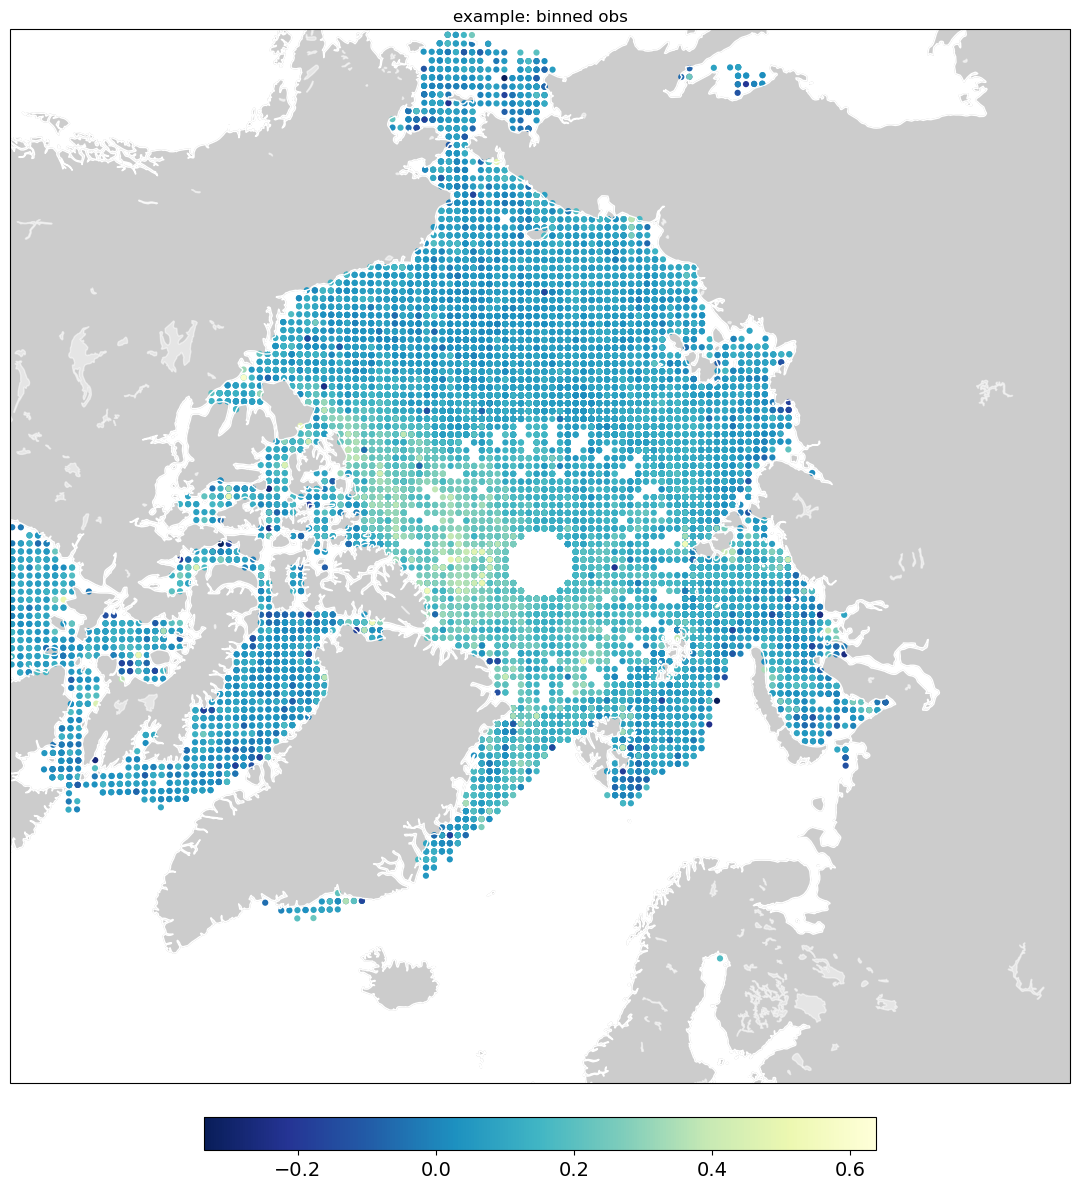

In [5]:
# this will plot all observations, some on top of each other
bin_df['lon'], bin_df['lat'] = EASE2toWGS84_New(bin_df['x'], bin_df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=bin_df['lon'],
                lat=bin_df['lat'],
                plot_data=bin_df['z'],
                title="example: binned obs",
                scatter=True,
                s=20,
                fig=fig,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

## Setting up configurations
Now, we set up the configuration dataclasses for interpolating this data using local GP experts. For the expert locations, we use points on an evenly spaced 200km grid. For this tutorial, we will only consider interpolating on a small square region around the pole.

In [6]:
# - spaced every 200km for some x,y range
xy_grid = grid_2d_flatten(x_range=[-500000.0, 500000.0],
                          y_range=[-500000.0, 500000.0],
                          step_size=200_000)

# store in dataframe
eloc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# add a time coordinate
eloc['t'] = np.floor(df['t'].mean())

print("Local expert locations:")
eloc.head()

Local expert locations:


,x,y,t
0,-400000.0,-400000.0,18326.0
1,-200000.0,-400000.0,18326.0
2,0.0,-400000.0,18326.0
3,200000.0,-400000.0,18326.0
4,400000.0,-400000.0,18326.0


We plot this below.

'plot_pcolormesh': 0.009 seconds


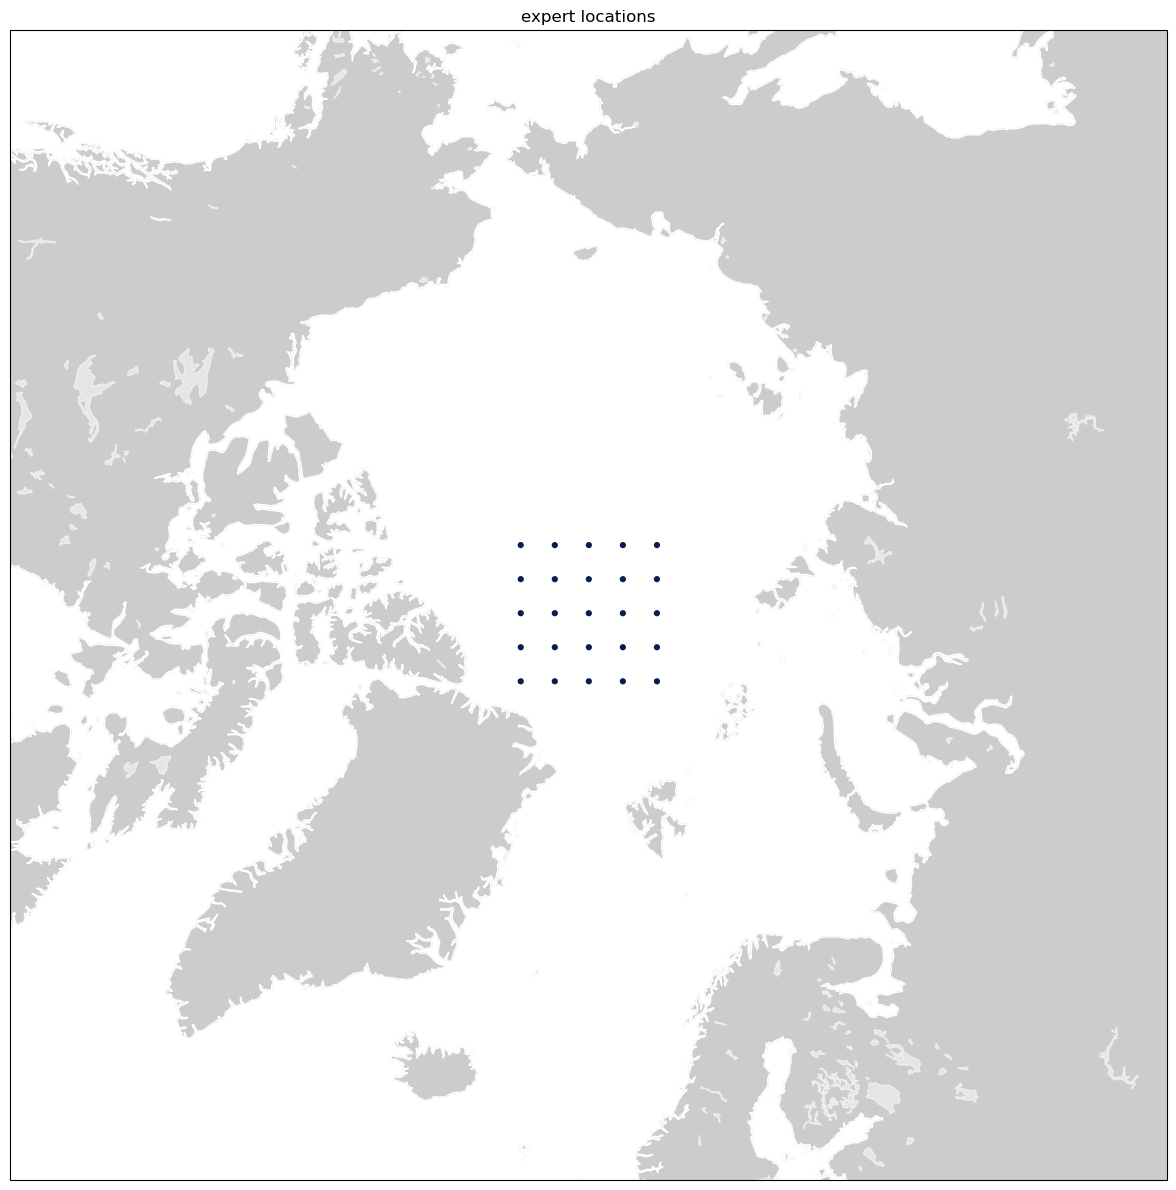

In [7]:
# plot expert locations
eloc['lon'], eloc['lat'] = EASE2toWGS84_New(eloc['x'], eloc['y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=eloc['lon'],
                lat=eloc['lat'],
                plot_data=eloc['t'],
                title="expert locations",
                scatter=True,
                s=20,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

For the prediction locations, we use points on a finer 5km grid.

In [8]:
# - spaced every 5km
xy_grid = grid_2d_flatten(x_range=[-500000.0, 500000.0],
                          y_range=[-500000.0, 500000.0],
                          step_size=5_000)

# store in dataframe
# NOTE: the missing 't' coordinate will be determine by the expert location
# - alternatively the prediction location can be specified
ploc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# Add lon-lat measurements
ploc['lon'], ploc['lat'] = EASE2toWGS84_New(ploc['x'], ploc['y'])

print("Prediction locations:")
ploc.head()

Prediction locations:


,x,y,lon,lat
0,-497500.0,-497500.0,-45.000000,83.697470
1,-492500.0,-497500.0,-44.710630,83.729095
2,-487500.0,-497500.0,-44.418337,83.760558
3,-482500.0,-497500.0,-44.123092,83.791856
4,-477500.0,-497500.0,-43.824867,83.822987


Again we plot this below.

'plot_pcolormesh': 0.038 seconds


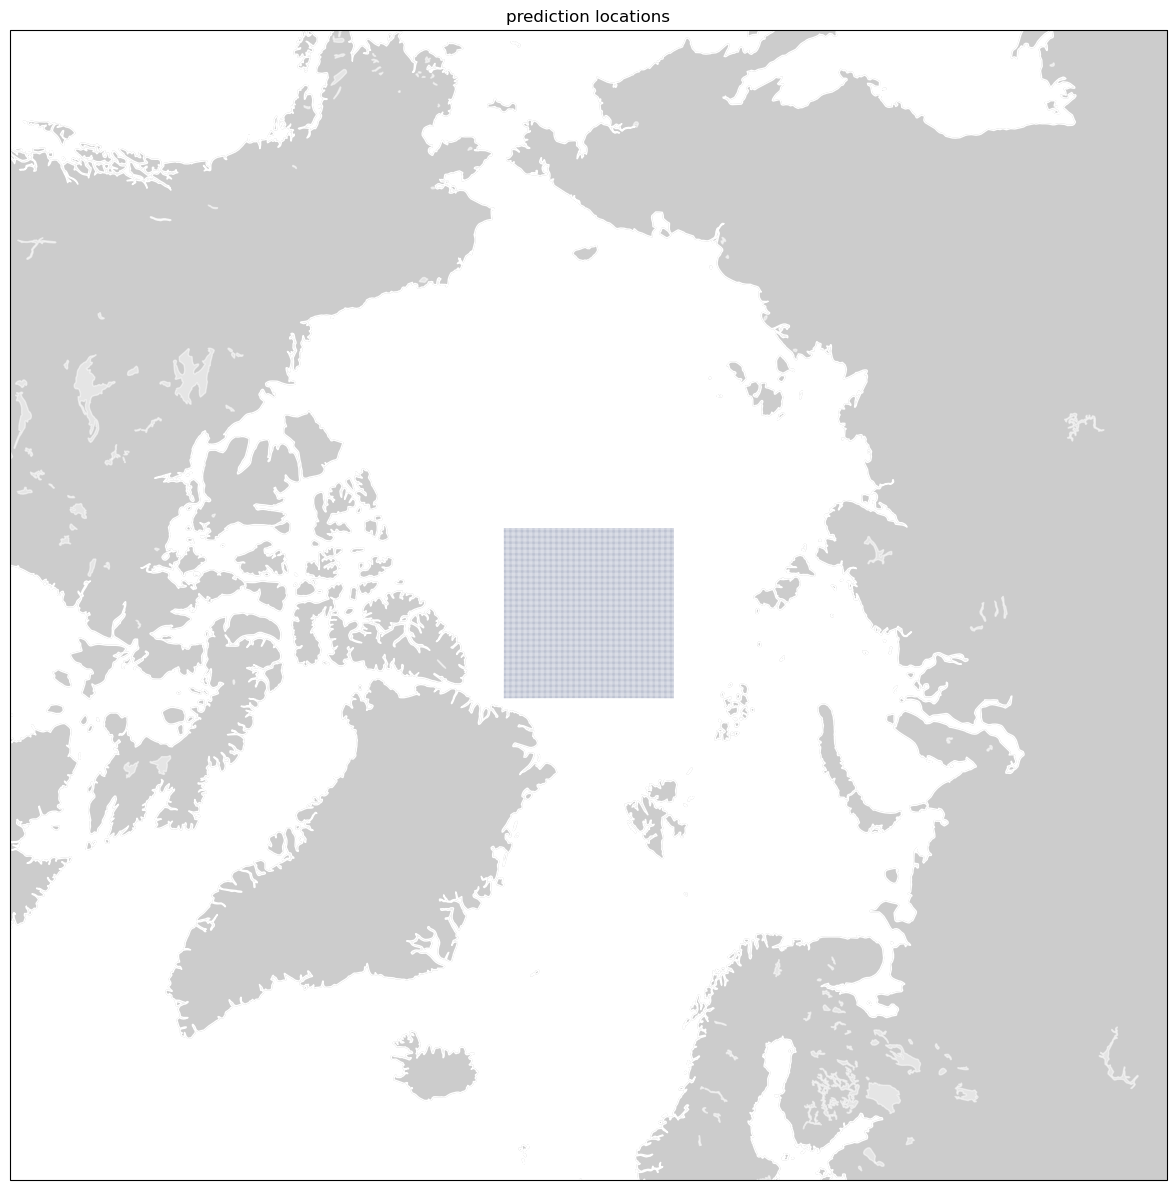

In [9]:
# plot prediction locations
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=ploc['lon'],
                lat=ploc['lat'],
                plot_data=np.full(len(ploc), 1.0), #np.arange(len(ploc)),
                title="prediction locations",
                scatter=True,
                s=0.1,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()


We now set up configurations for Local Expert OI

In [11]:
# Set training and inference radius
training_radius = 300_000   # 300km
inference_radius = 200_000  # 200km

# Local expert locations config
local_expert = ExpertLocsConfig(source = eloc)

# Model config
model = ModelConfig(oi_model = "GPflowGPRModel", # Use GPflow GPR model
                    init_params = {
                        # normalise xy coordinates by 50km
                        "coords_scale": [50_000, 50_000, 1]
                        },
                    constraints = {
                        # set bounds on the lengthscale hyperparameters
                        "lengthscales": {
                            "low": [1e-08, 1e-08, 1e-08],
                            "high": [600_000, 600_000, 9]
                        }
                        }
                    )

# Data config
data = DataConfig(data_source = bin_df,
                  obs_col = "z",
                  coords_col = ["x", "y", "t"],
                  local_select = [
                    # Select data within 300km and ± 4 days of the expert location
                    {"col": "t", "comp": "<=", "val": 4},
                    {"col": "t", "comp": ">=", "val": -4},
                    {"col": ["x", "y"], "comp": "<", "val": training_radius}
                  ]
                )

# Prediction locs config
pred_loc = PredictionLocsConfig(method = "from_dataframe",
                                df = ploc,
                                max_dist = inference_radius)


Set up Local Expert OI object from these configs.

In [12]:
locexp = LocalExpertOI(expert_loc_config = local_expert,
                       data_config = data,
                       model_config = model,
                       pred_loc_config = pred_loc)


'data_select': 0.000 seconds
'load': 0.001 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 22522 >  100
storing as str


/home/so/miniconda3/envs/gpsat/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/home/so/miniconda3/envs/gpsat/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 40000 >  100
storing as str


Specify a file to store results and run the experiment.

In [13]:
# path to store results
store_path = get_parent_path("results", "inline_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=store_path)

removing: /home/so/Documents/Projects/GPSat/results/inline_example.h5
---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details in the file'
will now close object

------------------------------
1 / 25
          x         y        t   lon        lat
0 -400000.0 -400000.0  18326.0 -45.0  84.933616
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.002 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'_update_global_data': 0.001 seconds
'local_data_select': 0.008 seconds
number obs: 402


2023-08-04 04:37:27.565541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
/home/so/miniconda3/envs/gpsat/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2023-08-04 04:37:27.566079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5
2023-08-04 04:37:27.573406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capabilit

found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 1.378 seconds
'get_parameters': 0.006 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:29.655025: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x5a3e2330


'optimise_parameters': 2.298 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([5.18430274, 3.21994817, 8.99996751]) 
kernel_variance: 0.015248077637888286
likelihood_variance: 0.003326551981572017
'predict': 0.072 seconds
total run time : 4.07 seconds
------------------------------
2 / 25
          x         y        t        lon      lat
1 -200000.0 -400000.0  18326.0 -26.565051  85.9952
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.005 seconds
number obs: 538
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.153 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:30.551057: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:30.551685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.921 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([3.77490227, 2.17837505, 8.9999992 ]) 
kernel_variance: 0.013368485065341336
likelihood_variance: 0.002011705387291524
'predict': 0.123 seconds
total run time : 1.52 seconds
------------------------------
3 / 25
     x         y        t  lon        lat
2  0.0 -400000.0  18326.0  0.0  86.418156
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.005 seconds
number obs: 519
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.144 seconds
'set_lengthscales_constraints': 0.013 seconds


2023-08-04 04:37:32.074940: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:32.075563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.786 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([4.40010794, 7.18116658, 8.9999986 ]) 
kernel_variance: 0.009121438644330735
likelihood_variance: 0.0018969360376774843
'predict': 0.088 seconds
total run time : 1.37 seconds
------------------------------
4 / 25
          x         y        t        lon      lat
3  200000.0 -400000.0  18326.0  26.565051  85.9952
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 525
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.146 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:33.450975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:33.451700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.897 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([6.84330385, 6.23896998, 8.99989554]) 
kernel_variance: 0.014942419505888406
likelihood_variance: 0.0016662916353139344
'predict': 0.124 seconds
total run time : 1.50 seconds
------------------------------
5 / 25
          x         y        t   lon        lat
4  400000.0 -400000.0  18326.0  45.0  84.933616
'_max_dist_bool': 0.000 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 409
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.143 seconds
'set_lengthscales_constraints': 0.016 seconds


2023-08-04 04:37:34.950917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:34.951523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.676 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([6.71014575, 4.73257294, 8.99998436]) 
kernel_variance: 0.013181914000795594
likelihood_variance: 0.00163091119321135
'predict': 0.078 seconds
total run time : 1.22 seconds
------------------------------
6 / 25
          x         y        t        lon      lat
5 -400000.0 -200000.0  18326.0 -63.434949  85.9952
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.005 seconds
number obs: 566
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.150 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:36.171014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:36.171609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


**********
optimization failed!
'optimise_parameters': 1.005 seconds
'get_parameters': 0.013 seconds
parameters:
lengthscales: array([6.87690624, 9.4225506 , 3.38488481]) 
kernel_variance: 0.023417548625691998
likelihood_variance: 0.0024453989847912855
'predict': 0.122 seconds
total run time : 1.62 seconds
------------------------------
7 / 25
          x         y        t   lon        lat
6 -200000.0 -200000.0  18326.0 -45.0  87.467477
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.005 seconds
number obs: 548
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.141 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:37.790365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:37.790899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 1.013 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([ 6.46137509, 11.99999997,  8.99998578]) 
kernel_variance: 0.028391599729726675
likelihood_variance: 0.0018270094089896064
'predict': 0.132 seconds
total run time : 1.63 seconds
------------------------------
8 / 25
     x         y        t  lon        lat
7  0.0 -200000.0  18326.0  0.0  88.209314
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 501
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.146 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:39.422441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:39.422972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.695 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([6.08673673, 5.81860783, 8.9999974 ]) 
kernel_variance: 0.009910739294832627
likelihood_variance: 0.0015218564242919807
'predict': 0.104 seconds
total run time : 1.27 seconds
------------------------------
9 / 25
          x         y        t   lon        lat
8  200000.0 -200000.0  18326.0  45.0  87.467477
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.005 seconds
number obs: 525
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.148 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:40.690506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:40.691043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.621 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([8.09483424, 4.33117385, 8.17983155]) 
kernel_variance: 0.013010832797257675
likelihood_variance: 0.0012718490211587091
'predict': 0.112 seconds
total run time : 1.23 seconds
------------------------------
10 / 25
          x         y        t        lon      lat
9  400000.0 -200000.0  18326.0  63.434949  85.9952
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 569
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.166 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:41.950437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:41.950993: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.958 seconds
'get_parameters': 0.016 seconds
parameters:
lengthscales: array([11.92741128,  6.49489885,  8.72231809]) 
kernel_variance: 0.013973494692672752
likelihood_variance: 0.0016707091544529843
'predict': 0.131 seconds
SAVING RESULTS
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 1.74 seconds
------------------------------
11 / 25
           x    y        t   lon        lat
10 -400000.0  0.0  18326.0 -90.0  86.418156
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.002 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 591
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.160 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:43.690787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:43.691419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.938 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([ 7.24269112, 11.99999097,  3.80743149]) 
kernel_variance: 0.019559394410147
likelihood_variance: 0.002365707017837905
'predict': 0.093 seconds
total run time : 1.51 seconds
------------------------------
12 / 25
           x    y        t   lon        lat
11 -200000.0  0.0  18326.0 -90.0  88.209314
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 516
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.144 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:45.182957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:45.183597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.970 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([12.        , 11.99955559,  4.77477945]) 
kernel_variance: 0.027803056253347086
likelihood_variance: 0.0019514924830062765
'predict': 0.118 seconds
total run time : 1.55 seconds
------------------------------
13 / 25
      x    y        t  lon   lat
12  0.0  0.0  18326.0  0.0  90.0
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.005 seconds
number obs: 522
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.172 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:46.747280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:46.747910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 1.247 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([10.79967918,  9.27697334,  8.99998398]) 
kernel_variance: 0.012821759790435464
likelihood_variance: 0.0009243603989098752
'predict': 0.110 seconds
total run time : 1.84 seconds
------------------------------
14 / 25
           x    y        t   lon        lat
13  200000.0  0.0  18326.0  90.0  88.209314
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 501
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.159 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:48.586725: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:48.587330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.713 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([10.88390894,  5.80588899,  8.99989577]) 
kernel_variance: 0.014744247293771849
likelihood_variance: 0.0012912814424961255
'predict': 0.091 seconds
total run time : 1.30 seconds
------------------------------
15 / 25
           x    y        t   lon        lat
14  400000.0  0.0  18326.0  90.0  86.418156
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 564
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.170 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:49.899102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:49.899784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.786 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([9.75711622, 6.26282712, 8.99945651]) 
kernel_variance: 0.008281458731449825
likelihood_variance: 0.0013507669281756232
'predict': 0.123 seconds
total run time : 1.41 seconds
------------------------------
16 / 25
           x         y        t         lon      lat
15 -400000.0  200000.0  18326.0 -116.565051  85.9952
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 556
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.142 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:51.278621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:51.279209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 1.438 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([ 7.10967544, 11.99999236,  3.40253469]) 
kernel_variance: 0.02040313975577633
likelihood_variance: 0.00196886246616167
'predict': 0.109 seconds
total run time : 2.01 seconds
------------------------------
17 / 25
           x         y        t    lon        lat
16 -200000.0  200000.0  18326.0 -135.0  87.467477
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 556
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.144 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:53.294650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:53.295229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


**********
optimization failed!
'optimise_parameters': 1.332 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([11.99980161, 11.9999889 ,  3.79068085]) 
kernel_variance: 0.021748034886230713
likelihood_variance: 0.0017348414859504225
'predict': 0.140 seconds
total run time : 1.95 seconds
------------------------------
18 / 25
      x         y        t    lon        lat
17  0.0  200000.0  18326.0  180.0  88.209314
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 513
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.159 seconds
'set_lengthscales_constraints': 0.008 seconds


2023-08-04 04:37:55.242901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:55.243525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.799 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([6.78170082, 7.24634317, 8.99975729]) 
kernel_variance: 0.008905692885363234
likelihood_variance: 0.001167462814267107
'predict': 0.107 seconds
total run time : 1.38 seconds
------------------------------
19 / 25
           x         y        t    lon        lat
18  200000.0  200000.0  18326.0  135.0  87.467477
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 532
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.151 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:56.622524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:56.623097: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.796 seconds
'get_parameters': 0.010 seconds
parameters:
lengthscales: array([ 7.46220407, 11.99946818,  8.99982619]) 
kernel_variance: 0.007192377444522425
likelihood_variance: 0.0014105586251045644
'predict': 0.128 seconds
total run time : 1.40 seconds
------------------------------
20 / 25
           x         y        t         lon      lat
19  400000.0  200000.0  18326.0  116.565051  85.9952
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 540
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.142 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:58.018330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:58.018879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.869 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([11.99993095,  7.62183178,  7.89619006]) 
kernel_variance: 0.010423402983965878
likelihood_variance: 0.0014468775416764854
'predict': 0.114 seconds
SAVING RESULTS
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 1.60 seconds
------------------------------
21 / 25
           x         y        t    lon        lat
20 -400000.0  400000.0  18326.0 -135.0  84.933616
'_max_dist_bool': 0.000 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 450
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.150 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:37:59.618823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:37:59.619453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.775 seconds
'get_parameters': 0.010 seconds
parameters:
lengthscales: array([11.99945162, 11.99999994,  3.00023603]) 
kernel_variance: 0.018768015530779256
likelihood_variance: 0.0017409763265880689
'predict': 0.092 seconds
total run time : 1.35 seconds
------------------------------
22 / 25
           x         y        t         lon      lat
21 -200000.0  400000.0  18326.0 -153.434949  85.9952
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 543
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.158 seconds
'set_lengthscales_constraints': 0.008 seconds


2023-08-04 04:38:00.975359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:38:00.976033: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 1.139 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([4.97029395, 8.53882672, 8.99998833]) 
kernel_variance: 0.010472317676643654
likelihood_variance: 0.0014508396770778684
'predict': 0.109 seconds
total run time : 1.72 seconds
------------------------------
23 / 25
      x         y        t    lon        lat
22  0.0  400000.0  18326.0  180.0  86.418156
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 552
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.171 seconds
'set_lengthscales_constraints': 0.008 seconds


2023-08-04 04:38:02.711457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:38:02.712103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.876 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([ 5.59758637, 11.99999187,  8.99999992]) 
kernel_variance: 0.008968927337090413
likelihood_variance: 0.0016418390748869104
'predict': 0.110 seconds
total run time : 1.48 seconds
------------------------------
24 / 25
           x         y        t         lon      lat
23  200000.0  400000.0  18326.0  153.434949  85.9952
'_max_dist_bool': 0.001 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 536
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.151 seconds
'set_lengthscales_constraints': 0.007 seconds


2023-08-04 04:38:04.178834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:38:04.179414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 0.784 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([11.99744084, 11.99988527,  8.99980585]) 
kernel_variance: 0.005548774431304691
likelihood_variance: 0.001461921097087148
'predict': 0.095 seconds
total run time : 1.35 seconds
------------------------------
25 / 25
           x         y        t    lon        lat
24  400000.0  400000.0  18326.0  135.0  84.933616
'_max_dist_bool': 0.000 seconds
'_from_dataframe': 0.001 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.006 seconds
number obs: 431
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.157 seconds
'set_lengthscales_constraints': 0.008 seconds


2023-08-04 04:38:05.542507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-04 04:38:05.543090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


**********
optimization failed!
'optimise_parameters': 1.065 seconds
'get_parameters': 0.013 seconds
parameters:
lengthscales: array([11.99999058,  7.11591239,  8.0551511 ]) 
kernel_variance: 0.005866258621836252
likelihood_variance: 0.001212848285940532
'predict': 0.091 seconds
total run time : 1.65 seconds
storing any remaining tables
SAVING RESULTS
run_details
preds
lengthscales
kernel_variance
likelihood_variance
'run': 41.365 seconds


Extract the results from the store path:

In [14]:
# extract, store in dict
dfs, _ = get_results_from_h5file(store_path)

print(f"tables in results file: {list(dfs.keys())}")


reading in results
getting all tables
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
tables in results file: ['expert_locs', 'kernel_variance', 'lengthscales', 'likelihood_variance', 'oi_config', 'preds', 'run_details']


In [15]:
preds_data = dfs["preds"]

preds_data.head()

,x,y,t,_dim_0,f*,f*_var,y_var,f_bar,pred_loc_x,pred_loc_y,pred_loc_t,lon,lat
0,-400000.0,-400000.0,18326.0,0,0.160929,0.000552,0.003878,0,-497500.0,-497500.0,18326.0,-45.0,84.933616
1,-400000.0,-400000.0,18326.0,1,0.162823,0.000549,0.003876,0,-492500.0,-497500.0,18326.0,-45.0,84.933616
2,-400000.0,-400000.0,18326.0,2,0.165083,0.000548,0.003874,0,-487500.0,-497500.0,18326.0,-45.0,84.933616
3,-400000.0,-400000.0,18326.0,3,0.167683,0.000547,0.003874,0,-482500.0,-497500.0,18326.0,-45.0,84.933616
4,-400000.0,-400000.0,18326.0,4,0.170599,0.000548,0.003874,0,-477500.0,-497500.0,18326.0,-45.0,84.933616


As before there are going to be overlapping predictions coming from different local experts hence we glue them together using the ``glue_local_predictions_2d()`` method.

In [17]:
# multiple local experts may make predictions at the same prediction location (pred_loc).
# - for each prediction at a given location, take we weighted combination
# - weights being a function of the distance to each local expert that made a prediction at a given location.

plt_data = glue_local_predictions_2d(preds_df=preds_data,
                                     pred_loc_cols=["pred_loc_x", "pred_loc_y"],
                                     xprt_loc_cols=["x", "y"],
                                     vars_to_glue=["f*", "f*_var"],
                                     inference_radius=inference_radius)

plt_data.head()


,pred_loc_x,pred_loc_y,f*,f*_var
0,-497500.0,-497500.0,0.160929,0.000552
1,-497500.0,-492500.0,0.163124,0.000554
2,-497500.0,-487500.0,0.165552,0.000554
3,-497500.0,-482500.0,0.168239,0.000553
4,-497500.0,-477500.0,0.171205,0.000552


We then plot this result:

'data_select': 0.001 seconds
'load': 0.002 seconds
'plot_pcolormesh': 0.038 seconds


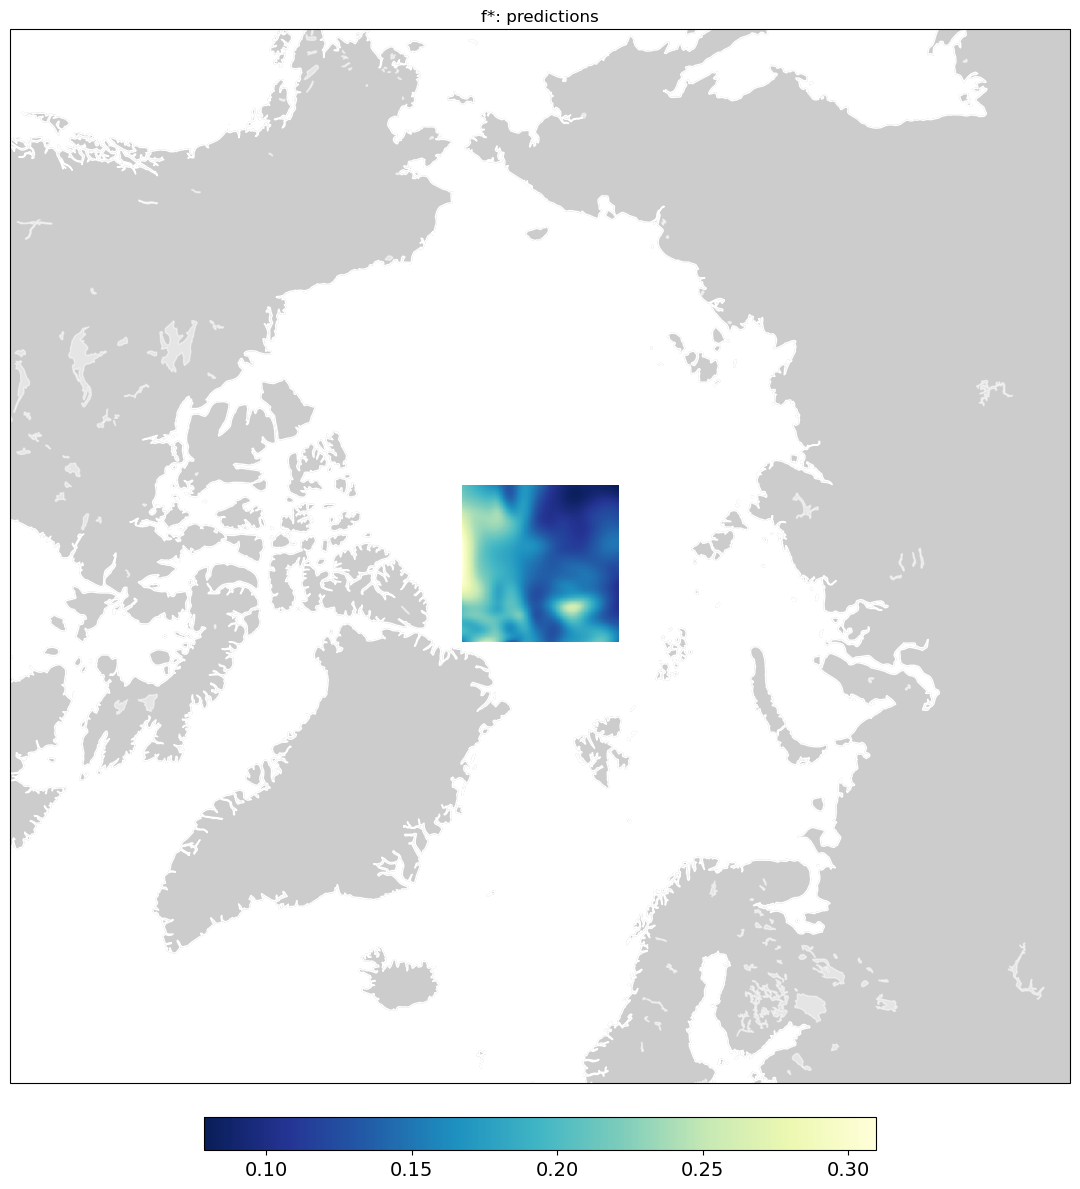

In [16]:
# add convert x,y to lon,lat
plt_data['lon'], plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'], plt_data['pred_loc_y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))
plot_pcolormesh_from_results_data(ax=ax,
                                  dfs={"preds": plt_data},
                                  table='preds',
                                  val_col="f*",
                                  scatter=False,
                                  x_col='pred_loc_x',
                                  y_col='pred_loc_y',
                                  fig=fig,
                                  plot_kwargs={"title": "f*: predictions"})
plt.tight_layout()
plt.show()
